# 线性神经网络

## 线性回归

$ x^2 $

### 正态分布

In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np


def normal_distribution(_x, _mu, _sigma):
    p = 1 / math.sqrt(2 * math.pi * _sigma ** 2)
    return p * np.exp(-0.5 / _sigma ** 2 * (_x - _mu) ** 2)


x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]

for mu, sigma in params:
    plt.plot(x, normal_distribution(x, mu, sigma), label=f'mean {mu}, standard-deviation {sigma}')

plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

plt.show()

### 人造数据集

In [ ]:
import torch
import matplotlib.pyplot as plt


# ⽣成y=Xw+b+噪声的合成数据函数
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成均值为0，标准差为1的正态分布随机特征数据
    y = torch.matmul(X, w) + b  # 计算标签y，y=Xw+b
    y += torch.normal(0, 0.01, y.shape)  # 添加均值为0，标准差为0.01的噪声
    return X, y.reshape((-1, 1))  # 返回特征数据X和标签数据y，将y reshape为列向量


true_w = torch.tensor([2, -3.4])  # 真实的权重向量w
true_b = 4.2  # 真实的偏置b
features, labels = synthetic_data(true_w, true_b, 1000)  # 生成1000个样本的合成数据

# 绘制特征(features)的第二列和对应标签(labels)的散点图
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# x轴标签
plt.xlabel('Feature 2')
# y轴标签
plt.ylabel('Label')
plt.title('Synthetic Data Scatter Plot')
# 显示散点图
plt.show()


In [ ]:
import random
import torch


def data_iter(batch_size, features, labels):
    """生成随机顺序的小批量样本"""
    num_examples = len(features)  # 获取样本数量
    indices = list(range(num_examples))  # 创建样本索引列表
    random.shuffle(indices)  # 将样本索引列表随机打乱，用于随机读取样本

    # 生成每个batch的样本集合
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])  # 获取当前batch的样本索引
        yield features[batch_indices], labels[batch_indices]  # 返回当前batch的特征和标签


w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b


def squared_loss(y_hat, y):
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


def sgd(params, lr, batch_size):
    """⼩批量随机梯度下降
    :param params: 要更新的参数列表
    :param lr: 学习率
    :param batch_size: 批量大小
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


# 设置超参数
lr = 0.03
num_epochs = 20
net = linreg
loss = squared_loss
batch_size = 90

# 外部循环遍历每个epoch
for epoch in range(num_epochs):
    # 内部循环遍历数据的每个batch
    for X, y in data_iter(batch_size, features, labels):
        # 计算当前batch的损失
        l = loss(net(X, w, b), y)
        # 求损失函数关于[w, b]的梯度
        l.sum().backward()
        # 使用随机梯度下降（SGD）更新参数[w, b]
        sgd([w, b], lr, batch_size)

    # 完成一个epoch后，计算整体的训练损失
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


### 使用框架

In [ ]:
import numpy as np
import torch
from torch.utils import data
from torch import nn

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造⼀个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


batch_size = 10
data_iter = load_array((features, labels), batch_size)

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

## softmax回归

### 分类问题

假设每次输⼊是⼀个2 × 2的灰度图像。我们可以⽤⼀个标量表⽰每个像素值，
每个图像对应四个特征$x_1, x_2, x_3, x_4$。此外，假设每个图像属于类别“猫”“鸡”和“狗”中的⼀个

使用独热编码（one-hot encoding）。独热编码是⼀个向量，它的分量和类别⼀样多。
类别对应的分量设置为1，其他所有分量设置为0。

例如：标签${\bf{y}}$将是⼀个三维向量，其中${(1,0,0)}^T$对应于“猫”、${(0,1,0)}^T$对应于“鸡”、${(0,0,1)}^T$对应于“狗”，那么输出${\bf{y}}$就可以表示为：

$$
{\bf{y}} \in {\begin{Bmatrix} {(1,0,0)}^T, & {(0,1,0)}^T, & {(0,0,1)}^T \end{Bmatrix}}
$$

为了估计所有可能类别的条件概率，需要⼀个有多个输出的模型，每个类别对应⼀个输出。
为了解决线性模型的分类问题，需要和输出⼀样多的仿射函数（affine function），每个输出对应于它⾃⼰的仿射函数。

在上述例子中，可以组成一个方程组：

$$
\begin{cases}
    {o_1} = {w_{11}}{x_1} + {w_{12}}{x_2} + {w_{13}}{x_3} + {w_{14}}{x_4} + {b_1} \\
    {o_2} = {w_{21}}{x_1} + {w_{22}}{x_2} + {w_{23}}{x_3} + {w_{24}}{x_4} + {b_2} \\
    {o_3} = {w_{31}}{x_1} + {w_{32}}{x_2} + {w_{33}}{x_3} + {w_{34}}{x_4} + {b_3} \\
\end{cases}
$$

同样使用线性代数表示：

$$
    {\bf{o}} = {\bf{W}} {\bf{x}} + {\bf{b}}
    \quad \text{其中} \quad
    {\bf{b}} \text{是一个偏置值}
$$

### softmax运算

$$
{\widehat{\bf{y}}} = softmax({\bf{o}}) 
\quad \text{其中} \quad
{\widehat{y}_i} = \frac{exp({o_i})}{\sum_{k=1}^{n}{exp({o_k})} }
$$

假设我们读取了⼀个批量的样本${\bf X}$,其中样本维度为$d$,批量⼤⼩为$n$.则$\bf X$可以表示为:

$$
{\bf{X}} = \begin{bmatrix} {\bf{x_1}} & {\bf{x_2}} & {\cdots} & {\bf{x_n}} \end{bmatrix}
$$

公式就可转为更一般的形式:

$$
{\bf{O}} = {\bf{W}} {\bf{X}} + {\bf{B}} 
\quad \text{其中} \quad
{\bf{B}} = \underbrace{ \begin{bmatrix} {\bf{b}} & {\bf{b}} & {\cdots} & {\bf{b}} \end{bmatrix}}_n \\\\[2ex]
{\widehat{\bf{Y}}} = softmax({\bf{O}}) 
$$

### 最大似然
softmax函数给出了⼀个估计向量${\widehat{\bf y}}$，我们可以将其视为“当输入样本为${\bf x}$时, 样本属于某一类的概率分布”。

例如:

$$ {\widehat{y}_1} = P( 样本为猫 | {\bf x})$$

意味着得到的向量${\widehat{\bf y}}$中的第一个元素$y_1$就是输入的样本${\bf x}$属于猫的概率,
${y_1}$越大,证明样本${\bf x}$越有可能属于猫.

假设我们的整个数据集$\{\bf X, \bf Y\}$具有$n$个样本，其中第$i$个样本由其特征向量${\bf x}_i$和对应的标签向量${\bf y}_i$组成

那么在这种已经得知观测结果的情况下,试图对其中的参数进行估计,即是**最大似然估计**.

softmax回归显然是离散型统计模型,其原始公式如下:

$$
L({\theta}) = \prod_{i=1}^n {P_{\theta}(X_i = x_i)} \quad i = 1,2,3,{\cdots},n
$$

在例子中即为:

$$
L: \quad \prod_{i=1}^n {P({\bf y}_i|{\bf x}_i)} \quad i = 1,2,3,{\cdots},n
$$

求${L_{max}}$即求$ {[-log(L)]}_{min} $

$$
{-log(L)} = - \sum_{i=1}^n log[{P({\bf y}_i|{\bf x}_i)}] = \sum_{i=1}^n loss({\bf y}_i,{\widehat{\bf y}}_i) \\
\text{其中}
L: loss({\bf y},{\widehat{\bf y}}) =  - \sum_{i=1}^n {y_i} \ln {{\widehat y}_i}
$$

为了使损失函数得到最小值，因此需要求其关于$o_i$的梯度：

$$
\dfrac{\partial L}{\partial o_i} = \sum_{j=1}^{n} \dfrac{\partial L}{\partial {{\widehat y}_j}} \, 
\dfrac{\partial {{\widehat y}_j}}{\partial o_i}
$$

其中：

$$
\begin{cases}
    \dfrac{\partial L}{\partial {{\widehat y}_j}} = - \dfrac{\partial{}}{\partial {{\widehat y}_j}} ({\sum_{i=1}^n {y_i} \ln {{\widehat y}_i}})\\[3ex]
    \dfrac{\partial {{\widehat y}_j}}{\partial o_i} = \dfrac{\partial{}}{\partial {o_i}} (\frac{exp({o_j})}{\sum_{k=1}^{n}{exp({o_k})} })
\end{cases},

\quad j = 1,2,3,{\cdots},n
$$

则有：

$$
while \quad i = j ,\qquad
 \dfrac{\partial {{\widehat y}_j}}{\partial o_i} 
 =  \dfrac{\partial {{\widehat y}_i}}{\partial o_i} 
 = \frac{ {exp({o_i})}{\sum_{k=1}^{n}{exp({o_k})}} - {exp({o_i})}^2 } {{\sum_{k=1}^{n}{exp({o_k})}}^2}
 = {{\widehat y}_i} - {{\widehat y}_i}^2

\\[4ex]

while \quad i \neq j ,\qquad
 \dfrac{\partial {{\widehat y}_j}}{\partial o_i} 
 = \frac{ 0 - {exp({o_i})} {exp({o_j})} } {{\sum_{k=1}^{n}{exp({o_k})}}^2}
 = - {{\widehat y}_i} {{\widehat y}_j}
$$

所以：
$$
\dfrac{\partial L}{\partial o_i} = 
    \dfrac{\partial L}{\partial {{\widehat y}_i}} ({{\widehat y}_i} - {{\widehat y}_i}^2) - (\sum_{j=1}^{n,j \neq i} \dfrac{\partial L}{\partial {{\widehat y}_j}} {{\widehat y}_i} {{\widehat y}_j})
$$

又因为：
$$
\dfrac{\partial L}{\partial {{\widehat y}_i}} = - \frac {y_i}{\widehat y}_i
$$

所以：
$$
\dfrac{\partial L}{\partial o_i} 
= {y_i} ({\widehat y}_i - 1) + {{\widehat y}_i}\sum_{j=1}^{n,j \neq i}  {{y}_j}
= {{\widehat y}_i}\sum_{j=1}^{n} {{y}_j} - {y_i}
= {{\widehat y}_i} - {y_i}
$$

Q.E.D

### 图像分类数据集

epoch: 29 |train_loss: 0.40751675821940103 |train_acc: 0.8595833333333334


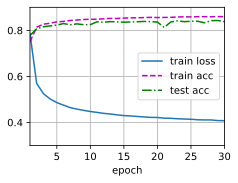

In [1]:
import torchvision
import torch
from torch.utils import data
from torchvision import transforms
from helper import algorithm as alog
from helper import utility as helper


def load_data_fashion_mnist(batch_size_input: int, workers: int = 4, resize=None):
    """下载Fashion-MNIST数据集,然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size_input, shuffle=True, num_workers=workers),
            data.DataLoader(mnist_test, batch_size_input, shuffle=False, num_workers=workers))


lr = 0.1
num_epochs = 30
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
num_inputs = 784
num_outputs = 10
w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


def get_fashion_mnist_labels(labels_input):
    """返回Fashion-MNIST数据集的⽂本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels_input]


def net(x_input: torch.Tensor, w_input: torch.Tensor = w, b_input: torch.Tensor = b) -> torch.Tensor:
    vector = x_input.reshape(-1, w_input.shape[0])
    return alog.softmax(torch.matmul(vector, w_input) + b_input)


def evaluate_accuracy(net_input, data_iter_input):
    """计算在指定数据集上模型的精度"""
    if isinstance(net_input, torch.nn.Module):
        net_input.eval()  # 将模型设置为评估模式
    metric = helper.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for data_x, data_y in data_iter_input:
            metric.add(alog.accuracy(net_input(data_x), data_y), data_y.numel())
    return metric[0] / metric[1]


def train_softmax_epoch(net_input, train_iter_input, loss_input, updater_input):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net_input, torch.nn.Module):
        net_input.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = helper.Accumulator(3)
    for x_train_data, y_train_data in train_iter_input:
        # 计算梯度并更新参数
        y_hat = net_input(x_train_data)
        loss_in = loss_input(y_hat, y_train_data)
        if isinstance(updater_input, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater_input.zero_grad()
            loss_in.mean().backward()
            updater_input.step()
        else:
            # 使用定制的优化器和损失函数
            loss_in.sum().backward()
            updater_input(x_train_data.shape[0])
        metric.add(float(loss_in.sum()), alog.accuracy(y_hat, y_train_data), y_train_data.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


def train_softmax_custom(net_input, train_iter_input, test_iter_input, loss_input, num_epochs_input, updater_input):
    animator = helper.Animator(xlabel='epoch', xlim=[1, num_epochs_input], ylim=[0.3, 0.9],
                               legend=['train loss', 'train acc', 'test acc'])
    for epoch_in in range(num_epochs_input):
        train_metrics = train_softmax_epoch(net_input, train_iter_input, loss_input, updater_input)
        test_acc = evaluate_accuracy(net_input, test_iter_input)
        animator.add(epoch_in + 1, train_metrics + (test_acc,))
        print("epoch:", epoch_in, "|train_loss:", train_metrics[0], "|train_acc:", train_metrics[1], end="\n")


def updater(batch_size_input: int, lr_input: int = lr, w_input: torch.Tensor = w, b_input: torch.Tensor = b):
    return alog.sgd([w_input, b_input], lr_input, batch_size_input)

def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

train_softmax_custom(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


In [ ]:
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

# PyTorch不会隐式地调整输⼊的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整⽹络输⼊的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weights)

loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 10
train_softmax_custom(net, train_iter, test_iter, loss, num_epochs, trainer)

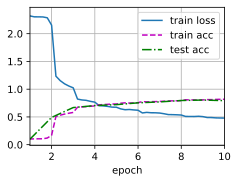

In [1]:
import torch
from torch import nn

from helper import algorithm
from helper import utility
from helper import fashion_mnist


def train(net_input, train_iter_input, test_iter_input, num_epochs_input, lr_input, device_input):
    def init_weights(m):
        if type(m) is nn.Linear or type(m) is nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net_input.apply(init_weights)
    print('training on', device_input)
    net_input.to(device_input)
    optimizer = torch.optim.SGD(net_input.parameters(), lr=lr_input)
    loss = nn.CrossEntropyLoss()
    animator = utility.Animator(xlabel='epoch', xlim=[1, num_epochs_input],
                                legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = utility.Timer(), len(train_iter)
    for epoch in range(num_epochs_input):
        # 训练损失之和，训练准确率之和，样本数
        metric = utility.Accumulator(3)
        net_input.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device_input), y.to(device_input)
            y_hat = net_input(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], algorithm.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
        test_acc = algorithm.evaluate_accuracy_gpu(net_input, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs_input / timer.sum():.1f} examples/sec 'f'on {str(device_input)}')


net = nn.Sequential(

    # 5x5卷积,周围填充两个像素,输出6张10x10的特征图
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),

    # 2x2平均池化,步长为2,每张图像缩小为14x14
    nn.AvgPool2d(kernel_size=2, stride=2),

    # 5x5卷积,每输入6张输出16张10x10的特征图
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),

    # 2x2平均池化,每张图像缩小为5x5
    nn.AvgPool2d(kernel_size=2, stride=2),

    # 全部展开为一维数据,共5x5x16=400个输入,准备全连接
    nn.Flatten(),

    # 第一层400->120
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),

    # 第二层120->84
    nn.Linear(120, 84),
    nn.Sigmoid(),

    # 第三层84->10
    nn.Linear(84, 10),
)

batch_size: int = 256
train_iter, test_iter = fashion_mnist.load_data(batch_size_input=batch_size)
lr: float = 0.9
num_epochs: int = 10

train(net, train_iter, test_iter, num_epochs, lr, utility.try_gpu())
